In [1]:
import sys
from pathlib import Path

# Add src directory to Python path
project_root = Path.cwd().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    print(f"Added {src_path} to Python path")

Added /Users/cooper/Desktop/hydro-forecasting/src to Python path


In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_lightning import seed_everything
from returns.result import Failure, Result, Success
from sklearn.pipeline import Pipeline

seed_everything(42, workers=True)

import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

Seed set to 42


In [3]:
import hydro_forecasting.experiment_utils.checkpoint_manager as checkpoint_manager
from hydro_forecasting.data.caravanify_parquet import CaravanifyParquet, CaravanifyParquetConfig
from hydro_forecasting.data.in_memory_datamodule import HydroInMemoryDataModule
from hydro_forecasting.model_evaluation.evaluators import TSForecastEvaluator
from hydro_forecasting.model_evaluation.hp_from_yaml import hp_from_yaml
from hydro_forecasting.model_evaluation.visualization import (
    plot_basin_performance_scatter,
    plot_horizon_performance_bars,
    plot_horizon_performance_boxplots,
    plot_model_cdf_grid,
)
from hydro_forecasting.models.dummy import LitRepeatLastValues, RepeatLastValuesConfig
from hydro_forecasting.models.ealstm import EALSTMConfig, LitEALSTM
from hydro_forecasting.models.tft import LitTFT, TFTConfig
from hydro_forecasting.models.tide import LitTiDE, TiDEConfig
from hydro_forecasting.models.tsmixer import LitTSMixer, TSMixerConfig
from hydro_forecasting.preprocessing.grouped import GroupedPipeline
from hydro_forecasting.preprocessing.normalize import NormalizeTransformer
from hydro_forecasting.preprocessing.standard_scale import StandardScaleTransformer


---

In [4]:
forcing_features = [
    "snow_depth_water_equivalent_mean",
    "surface_net_solar_radiation_mean",
    "surface_net_thermal_radiation_mean",
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "total_precipitation_sum",
]

static_features = [
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

target = "streamflow"

In [5]:
REGIONS = ["CA"]

COUNTRY = "tajikistan"

MODEL_TYPES = [
    "tft",
    "ealstm",
    "tide",
    "tsmixer",
]

EXPERIMENT_TYPES = {
    "pretrained": f"similar_catchments/similar-catchments_{COUNTRY.lower()}",
    "finetuned": f"finetune/finetune_from_similar_catchments_{COUNTRY.lower()}",
    "benchmark": f"benchmark/benchmark_{COUNTRY.lower()}",
    "low_hii": f"/Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_{COUNTRY.lower()}",
}

BASE_PATH = Path("/Users/cooper/Desktop/hydro-forecasting/experiments")


In [6]:
ealstm_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/ealstm.yaml"
tft_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tft.yaml"
tide_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tide.yaml"
tsmixer_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tsmixer.yaml"


tft_hp = hp_from_yaml("tft", tft_yaml)
tide_hp = hp_from_yaml("tide", tide_yaml)
ealstm_hp = hp_from_yaml("ealstm", ealstm_yaml)
tsmixer_hp = hp_from_yaml("tsmixer", tsmixer_yaml)

The following parameters were not found in the YAML file and will use defaults:
  - hidden_continuous_size (model-specific)
  - quantiles (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - future_forcing_projection_size (model-specific)
  - past_feature_projection_size (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - bias (model-specific)
  - bidirectional (model-specific)
  - bidirectional_fusion (model-specific)
  - future_hidden_size (model-specific)
  - future_layers (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)


In [7]:
TFT_config = TFTConfig(**tft_hp)
EALSTM_config = EALSTMConfig(**ealstm_hp)
TiDE_config = TiDEConfig(**tide_hp)
TSMixer_config = TSMixerConfig(**tsmixer_hp)

dummy_config = RepeatLastValuesConfig(
    input_len=ealstm_hp["input_len"],
    input_size=ealstm_hp["input_size"],
    output_len=ealstm_hp["output_len"],
)

---

In [8]:
def load_basin_ids(country: str) -> list[str]:
    """
    Function to load basins for a given country in Central Asia
    """
    # Make country lowercase and make the first letter uppercase
    country = country.lower()
    country = country.capitalize()

    if country != "Tajikistan" and country != "Kyrgyzstan":
        print("Country not supported")
        return []

    configs = CaravanifyParquetConfig(
        attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
        timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
        gauge_id_prefix="CA",
        use_hydroatlas_attributes=True,
        use_caravan_attributes=True,
        use_other_attributes=True,
    )

    caravan = CaravanifyParquet(configs)
    ca_basins = caravan.get_all_gauge_ids()
    caravan.load_stations(ca_basins)
    static_data = caravan.get_static_attributes()

    return list(static_data[static_data["country"] == country]["gauge_id"].unique())


country_ids = load_basin_ids(COUNTRY)

In [9]:
print(f"Found {len(country_ids)} total CA basins in {COUNTRY}")

Found 16 total CA basins in tajikistan


---

In [10]:
feature_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=forcing_features,
    group_identifier="gauge_id",
)

target_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline([("scaler", StandardScaleTransformer())])

preprocessing_config = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline, "columns": static_features},
}

In [11]:
region_time_series_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/timeseries/csv/{region}"
    for region in REGIONS
}

region_static_attributes_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/attributes/{region}" for region in REGIONS
}

In [12]:
data_modules = {
    name: HydroInMemoryDataModule(
        region_time_series_base_dirs=region_time_series_base_dirs,
        region_static_attributes_base_dirs=region_static_attributes_base_dirs,
        path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
        group_identifier="gauge_id",
        batch_size=2048,
        input_length=hp["input_len"],
        output_length=hp["output_len"],
        forcing_features=forcing_features,
        static_features=static_features,
        target=target,
        preprocessing_configs=preprocessing_config,
        num_workers=4,
        min_train_years=5,
        train_prop=0.5,
        val_prop=0.25,
        test_prop=0.25,
        max_imputation_gap_size=5,
        list_of_gauge_ids_to_process=country_ids,
        is_autoregressive=True,
        chunk_size=100,
        validation_chunk_size=100,
    )
    for name, hp in [
        ("tft_data_module", tft_hp),
        ("tide_data_module", tide_hp),
        ("tsmixer_data_module", tsmixer_hp),
        ("ealstm_data_module", ealstm_hp),
    ]
}

tft_data_module = data_modules["tft_data_module"]
tide_data_module = data_modules["tide_data_module"]
tsmixer_data_module = data_modules["tsmixer_data_module"]
ealstm_data_module = data_modules["ealstm_data_module"]

In [13]:
def get_checkpoint_for_model(model_type: str, checkpoint_folder: Path, select_overall_best: bool = True):
    """
    Function to get the best checkpoint for a given model type
    """
    result = checkpoint_manager.get_checkpoint_path_to_load(
        base_checkpoint_load_dir=checkpoint_folder, model_type=model_type, select_overall_best=select_overall_best
    )
    return result


def unwrap(checkpoint: Result) -> Path:
    """
    Function to unwrap the checkpoint result
    """
    if isinstance(checkpoint, Failure):
        print(f"Failed to load checkpoint: {checkpoint.failure()}")
        return None
    elif isinstance(checkpoint, Success):
        return checkpoint.unwrap()


def load_all_checkpoints(country: str, model_types: list = None, experiment_types: dict = None):
    """
    Load checkpoints for all model types across all experiment types

    Args:
        country: Country code for the experiments
        model_types: List of model types to load (defaults to common ones)
        experiment_types: Dict mapping experiment names to directory patterns

    Returns:
        Dict of {experiment_type: {model_type: checkpoint_path}}
    """

    # Default model types
    if model_types is None:
        model_types = ["tft", "tide", "ealstm", "tsmixer"]

    base_path = BASE_PATH
    checkpoints = {}

    for exp_name, exp_path in experiment_types.items():
        checkpoints[exp_name] = {}
        checkpoint_dir = base_path / exp_path / "checkpoints"

        for model_type in model_types:
            checkpoint = unwrap(
                get_checkpoint_for_model(
                    model_type=model_type, checkpoint_folder=checkpoint_dir, select_overall_best=True
                )
            )
            checkpoints[exp_name][model_type] = checkpoint

    return checkpoints


def print_checkpoints(checkpoints: dict):
    """Print checkpoints in a readable format"""
    for exp_name, models in checkpoints.items():
        model_paths = [str(path) for path in models.values()]
        print(f"{exp_name.capitalize()} checkpoints: {', '.join(model_paths)}")


checkpoints = load_all_checkpoints(COUNTRY, MODEL_TYPES, EXPERIMENT_TYPES)
print_checkpoints(checkpoints)


Failed to load checkpoint: Base checkpoint load directory does not exist or is not a directory: /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints
Failed to load checkpoint: Base checkpoint load directory does not exist or is not a directory: /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints
Failed to load checkpoint: Base checkpoint load directory does not exist or is not a directory: /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints
Failed to load checkpoint: Base checkpoint load directory does not exist or is not a directory: /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints
Pretrained checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/similar_catchments/similar-catchments_tajikistan/checkpoints/tft/run_0/attempt_0/tft-run0-attempt_0-epoch=28-val_loss=0.

In [14]:
tft_pretrained_checkpoint = checkpoints["pretrained"]["tft"]
tide_pretrained_checkpoint = checkpoints["pretrained"]["tide"]
ealstm_pretrained_checkpoint = checkpoints["pretrained"]["ealstm"]
tsmixer_pretrained_checkpoint = checkpoints["pretrained"]["tsmixer"]

tft_finetuned_checkpoint = checkpoints["finetuned"]["tft"]
tide_finetuned_checkpoint = checkpoints["finetuned"]["tide"]
ealstm_finetuned_checkpoint = checkpoints["finetuned"]["ealstm"]
tsmixer_finetuned_checkpoint = checkpoints["finetuned"]["tsmixer"]

tft_benchmark_checkpoint = checkpoints["benchmark"]["tft"]
tide_benchmark_checkpoint = checkpoints["benchmark"]["tide"]
ealstm_benchmark_checkpoint = checkpoints["benchmark"]["ealstm"]
tsmixer_benchmark_checkpoint = checkpoints["benchmark"]["tsmixer"]

tft_low_hii_checkpoint = checkpoints["low_hii"]["tft"]
tide_low_hii_checkpoint = checkpoints["low_hii"]["tide"]

In [15]:
dummy_model = LitRepeatLastValues(config=dummy_config)
ealstm_benchmark_model = LitEALSTM.load_from_checkpoint(ealstm_benchmark_checkpoint, config=EALSTM_config)
tide_benchmark_model = LitTiDE.load_from_checkpoint(tide_benchmark_checkpoint, config=TiDE_config)
tsmixer_benchmark_model = LitTSMixer.load_from_checkpoint(tsmixer_benchmark_checkpoint, config=TSMixer_config)
tft_benchmark_model = LitTFT.load_from_checkpoint(tft_benchmark_checkpoint, config=TFT_config)

ealstm_pretrained_model = LitEALSTM.load_from_checkpoint(ealstm_pretrained_checkpoint, config=EALSTM_config)
tide_pretrained_model = LitTiDE.load_from_checkpoint(tide_pretrained_checkpoint, config=TiDE_config)
tsmixer_pretrained_model = LitTSMixer.load_from_checkpoint(tsmixer_pretrained_checkpoint, config=TSMixer_config)
tft_pretrained_model = LitTFT.load_from_checkpoint(tft_pretrained_checkpoint, config=TFT_config)

ealstm_finetuned_model = LitEALSTM.load_from_checkpoint(ealstm_finetuned_checkpoint, config=EALSTM_config)
tide_finetuned_model = LitTiDE.load_from_checkpoint(tide_finetuned_checkpoint, config=TiDE_config)
tsmixer_finetuned_model = LitTSMixer.load_from_checkpoint(tsmixer_finetuned_checkpoint, config=TSMixer_config)
tft_finetuned_model = LitTFT.load_from_checkpoint(tft_finetuned_checkpoint, config=TFT_config)

# tft_low_hii_model = LitTFT.load_from_checkpoint(tft_low_hii_checkpoint, config=TFT_config)
# tide_low_hii_model = LitTiDE.load_from_checkpoint(tide_low_hii_checkpoint, config=TiDE_config)


# Create a dictionary mapping model names to (model, datamodule) tuples
models_and_datamodules = {
    "ealstm_benchmark": (ealstm_benchmark_model, ealstm_data_module),
    "ealstm_pretrained": (ealstm_pretrained_model, ealstm_data_module),
    "ealstm_finetuned": (ealstm_finetuned_model, ealstm_data_module),
    "tide_benchmark": (tide_benchmark_model, tide_data_module),
    "tide_pretrained": (tide_pretrained_model, tide_data_module),
    "tide_finetuned": (tide_finetuned_model, tide_data_module),
    "tsmixer_benchmark": (tsmixer_benchmark_model, tsmixer_data_module),
    "tsmixer_pretrained": (tsmixer_pretrained_model, tsmixer_data_module),
    "tsmixer_finetuned": (tsmixer_finetuned_model, tsmixer_data_module),
    "tft_benchmark": (tft_benchmark_model, tft_data_module),
    "tft_pretrained": (tft_pretrained_model, tft_data_module),
    "tft_finetuned": (tft_finetuned_model, tft_data_module),
    # "tft_low_hii": (tft_low_hii_model, tft_data_module),
    # "tide_low_hii": (tide_low_hii_model, tide_data_module),
    "dummy": (dummy_model, ealstm_data_module),
}


evaluator = TSForecastEvaluator(
    horizons=list(range(1, 11)),
    models_and_datamodules=models_and_datamodules,
    trainer_kwargs={"accelerator": "cpu", "devices": 1, "deterministic": True, "benchmark": False},
)

In [16]:
# Run evaluation
results = evaluator.test_models(
    start_of_season=4,
    end_of_season=10,
    cache_path=f"/Users/cooper/Desktop/hydro-forecasting/tests/model_evaluation_cache_{COUNTRY.lower()}",
)

2025-06-19 10:32:01,153 - hydro_forecasting.model_evaluation.evaluators - INFO - Cache found at /Users/cooper/Desktop/hydro-forecasting/tests/model_evaluation_cache_tajikistan
2025-06-19 10:32:01,154 - hydro_forecasting.model_evaluation.evaluators - INFO - Found 13 cached models
2025-06-19 10:32:01,155 - hydro_forecasting.model_evaluation.evaluators - INFO - Loading cached results for: ealstm_benchmark, ealstm_pretrained, ealstm_finetuned, tide_benchmark, tide_pretrained, tide_finetuned, tsmixer_benchmark, tsmixer_pretrained, tsmixer_finetuned, tft_benchmark, tft_pretrained, tft_finetuned, dummy (13/13 models)


In [17]:
sns.set_context(context="paper", font_scale=1.3)

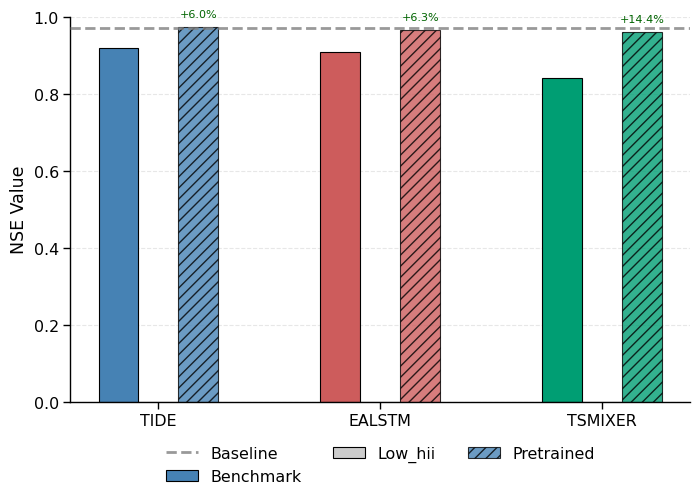

In [18]:
fig, ax = plot_horizon_performance_bars(
    results,
    horizon=1,
    metric="nse",
    architectures=["tide", "ealstm", "tsmixer"],
    variants=["benchmark", "low_hii", "pretrained"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(8, 5),
    with_whiskers=False,
    positive_is_better=True,
    dummy_model="dummy",
)
ax.set_ylim(0, 1)
sns.despine()
plt.show()


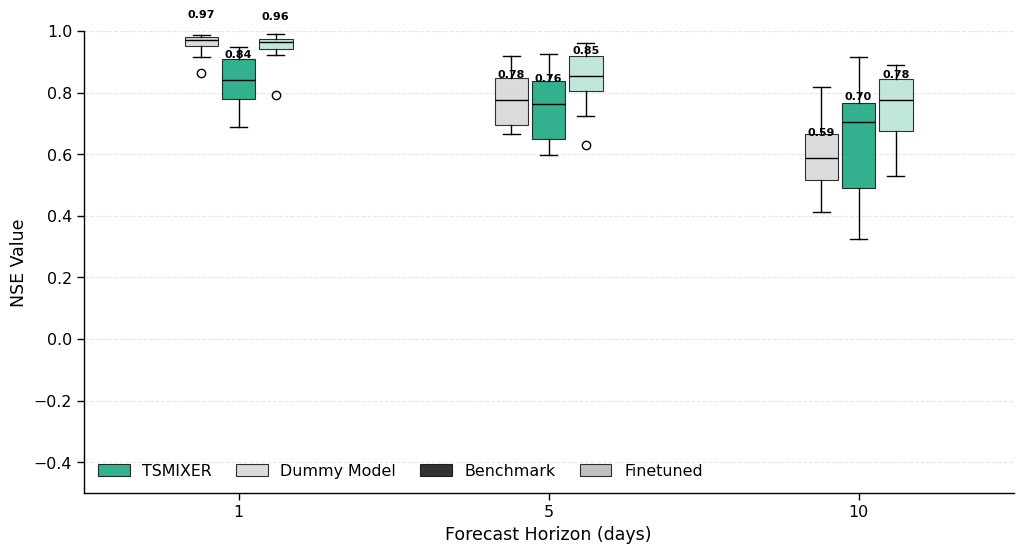

In [19]:
fig, ax = plot_horizon_performance_boxplots(
    results,
    horizons=[1, 5, 10],
    metric="nse",
    architectures=["tsmixer"],
    variants=["benchmark", "finetuned"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(12, 6),
    show_median_labels=True,
    dummy_model="dummy",
)

ax.set_ylim(-0.5, 1)
ax.set_title("")
sns.despine()
plt.show()


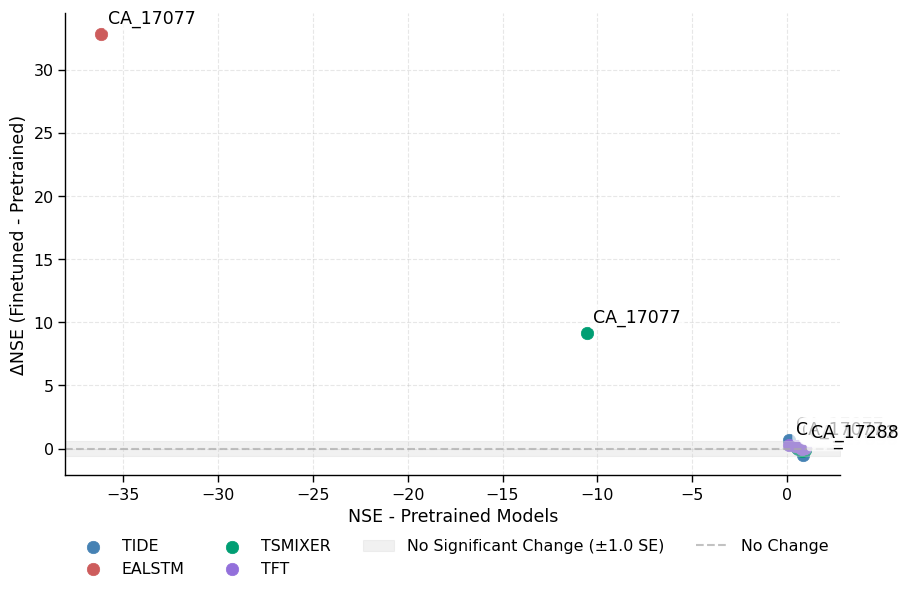

In [20]:
fig, ax = plot_basin_performance_scatter(
    results,
    benchmark_pattern="pretrained",
    challenger_pattern="finetuned",
    horizon=10,
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    metric="nse",
    figsize=(10, 6),
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    debug=True,
)
sns.despine()
plt.show()

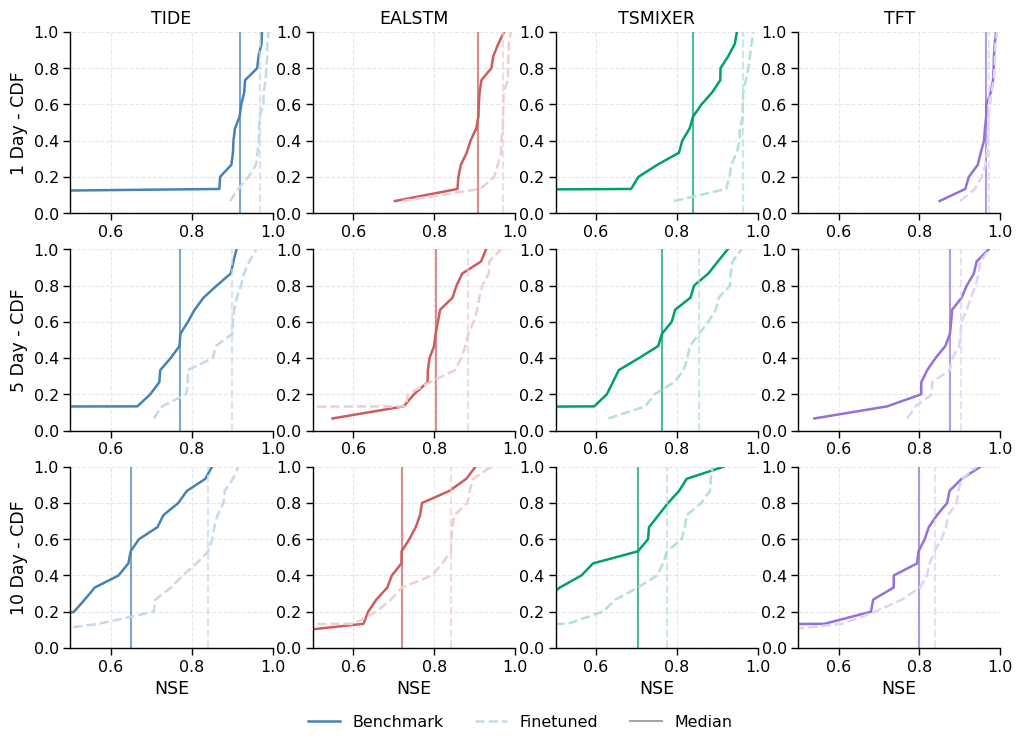

In [21]:
fig, axes = plot_model_cdf_grid(
    results,
    horizons=[1, 5, 10],
    metric="nse",
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    variants=["benchmark", "finetuned"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(12, 8),
)
sns.despine()
plt.show()

In [22]:
# fig, ax = plot_rolling_forecast(
#     results,
#     model_name="tsmixer_finetuned",
#     gauge_id="CA_15016",
#     horizon=1,
#     figsize=(10, 5),
#     color_scheme={"observed": "#2E4057", "predicted": "#FF6B35"},
# )

# sns.despine()
# ax.set_xlabel("")
# ax.set_ylabel("Streamflow (mm/day)")

# plt.show()

In [23]:
# config_ca = CaravanifyParquetConfig(
#     attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
#     timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
#     shapefile_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/shapefiles",
#     gauge_id_prefix="CA",
#     use_hydroatlas_attributes=True,
#     use_caravan_attributes=True,
#     use_other_attributes=True,
# )

# caravan_ca = CaravanifyParquet(config_ca)

# caravan_ca._load_static_attributes(country_ids)
# statics = caravan_ca.get_static_attributes()


# fig, axes = plot_performance_vs_static_attributes(
#     results,
#     static_df=statics,
#     static_attributes=["p_mean", "ele_mt_sav", "frac_snow"],
#     model_names=["tide_low_hii"],
#     horizons=[5],
#     metric="nse",
#     figsize=(11, 4),
#     attribute_labels={
#         "p_mean": "Mean Precipitation (mm/d)",
#         "ele_mt_sav": "Mean Elevation (m.a.s.l.)",
#         "frac_snow": "Precipitation Falling as Snow (%)",
#     },
# )

# sns.despine()
# # set y lim to (0, 1)
# for ax in axes.flatten():
#     ax.set_ylim(0.0, 1)
#     ax.set_title("")
# plt.show()
